In [1]:
import os
import glob
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

BASE_DIR = r"C:\Users\guilh\OneDrive\Ambiente de Trabalho\novos projeto Ai\ds1\modelos\runs\detect"


RUN_NAMES = ["8l", "8m", "8n", "11l", "11m", "11n"]

DO_THRESHOLD_SWEEP = True
CONF_GRID = np.linspace(0.05, 0.95, 19)  #
IOU_FOR_F1 = 0.50


def find_run_dir(name: str) -> str:
    p = os.path.join(BASE_DIR, name)
    if os.path.isdir(p):
        return p
    raise FileNotFoundError(f"Não encontrei a pasta do run: {p}")

def load_results_csv(run_dir: str) -> pd.DataFrame:
    csv_path = os.path.join(run_dir, "results.csv")
    if not os.path.isfile(csv_path):
        candidates = glob.glob(os.path.join(run_dir, "**", "results.csv"), recursive=True)
        if not candidates:
            raise FileNotFoundError(f"Não encontrei results.csv em {run_dir}")
        csv_path = candidates[0]
    df = pd.read_csv(csv_path)
    df.columns = [c.strip() for c in df.columns]
    return df, csv_path

def get_best_epoch(df: pd.DataFrame, metric_col="metrics/mAP50-95(B)") -> int:
    if metric_col not in df.columns:
        alt = [c for c in df.columns if "mAP50-95" in c]
        if alt:
            metric_col = alt[0]
        else:
            raise KeyError("Não encontrei coluna mAP50-95 no results.csv")
    return int(df[metric_col].idxmax())

def parse_args_yaml(run_dir: str) -> dict:
    p = os.path.join(run_dir, "args.yaml")
    if not os.path.isfile(p):
        candidates = glob.glob(os.path.join(run_dir, "**", "args.yaml"), recursive=True)
        if not candidates:
            return {}
        p = candidates[0]
    with open(p, "r", encoding="utf-8") as f:
        return yaml.safe_load(f)

def safe_get(df, col, idx):
    return df.loc[idx, col] if col in df.columns else np.nan

def plot_run_curves(run_name: str, df: pd.DataFrame):
    cols = df.columns.tolist()

    train_box = "train/box_loss" if "train/box_loss" in cols else None
    val_box   = "val/box_loss" if "val/box_loss" in cols else None

    train_cls = "train/cls_loss" if "train/cls_loss" in cols else None
    val_cls   = "val/cls_loss" if "val/cls_loss" in cols else None

    train_dfl = "train/dfl_loss" if "train/dfl_loss" in cols else None
    val_dfl   = "val/dfl_loss" if "val/dfl_loss" in cols else None

    p_col  = "metrics/precision(B)" if "metrics/precision(B)" in cols else None
    r_col  = "metrics/recall(B)" if "metrics/recall(B)" in cols else None
    m50    = "metrics/mAP50(B)" if "metrics/mAP50(B)" in cols else None
    m5095  = "metrics/mAP50-95(B)" if "metrics/mAP50-95(B)" in cols else None

    fig, ax = plt.subplots(figsize=(10, 4))
    if train_box and val_box:
        ax.plot(df.index, df[train_box], label="train/box_loss")
        ax.plot(df.index, df[val_box], label="val/box_loss")
    if train_cls and val_cls:
        ax.plot(df.index, df[train_cls], label="train/cls_loss", alpha=0.7)
        ax.plot(df.index, df[val_cls], label="val/cls_loss", alpha=0.7)
    if train_dfl and val_dfl:
        ax.plot(df.index, df[train_dfl], label="train/dfl_loss", alpha=0.7)
        ax.plot(df.index, df[val_dfl], label="val/dfl_loss", alpha=0.7)

    ax.set_title(f"{run_name} — Loss: train vs val (sinais de overfitting)")
    ax.set_xlabel("Epoch (index do results.csv)")
    ax.set_ylabel("Loss")
    ax.legend()
    ax.grid(True)
    plt.show()

    fig, ax = plt.subplots(figsize=(10, 4))
    if m50:   ax.plot(df.index, df[m50],   label="mAP50 (B)")
    if m5095: ax.plot(df.index, df[m5095], label="mAP50-95 (B)")
    if p_col: ax.plot(df.index, df[p_col], label="Precision (B)", alpha=0.7)
    if r_col: ax.plot(df.index, df[r_col], label="Recall (B)", alpha=0.7)

    ax.set_title(f"{run_name} — Métricas de validação ao longo das épocas")
    ax.set_xlabel("Epoch (index do results.csv)")
    ax.set_ylabel("Score")
    ax.legend()
    ax.grid(True)
    plt.show()

def overfit_indicators(df: pd.DataFrame) -> dict:
    """
    Heurísticas simples:
    - best_epoch (max mAP50-95)
    - queda do best -> last (se caiu, pode ter overfit após o pico)
    - gap de box_loss (val - train) no final
    """
    cols = df.columns.tolist()
    m5095 = "metrics/mAP50-95(B)" if "metrics/mAP50-95(B)" in cols else [c for c in cols if "mAP50-95" in c][0]
    m50   = "metrics/mAP50(B)" if "metrics/mAP50(B)" in cols else [c for c in cols if "mAP50(B)" in c][0]
    p_col = "metrics/precision(B)" if "metrics/precision(B)" in cols else [c for c in cols if "precision" in c.lower()][0]
    r_col = "metrics/recall(B)" if "metrics/recall(B)" in cols else [c for c in cols if "recall" in c.lower()][0]

    best_idx = int(df[m5095].idxmax())
    last_idx = int(df.index.max())

    train_box = "train/box_loss" if "train/box_loss" in cols else None
    val_box   = "val/box_loss" if "val/box_loss" in cols else None

    gap_box_last = np.nan
    if train_box and val_box:
        gap_box_last = float(df.loc[last_idx, val_box] - df.loc[last_idx, train_box])

    return {
        "best_epoch_idx": best_idx,
        "last_epoch_idx": last_idx,
        "best_mAP50": float(df.loc[best_idx, m50]),
        "best_mAP50_95": float(df.loc[best_idx, m5095]),
        "last_mAP50": float(df.loc[last_idx, m50]),
        "last_mAP50_95": float(df.loc[last_idx, m5095]),
        "drop_best_to_last_mAP50_95": float(df.loc[best_idx, m5095] - df.loc[last_idx, m5095]),
        "best_precision": float(df.loc[best_idx, p_col]),
        "best_recall": float(df.loc[best_idx, r_col]),
        "gap_val_minus_train_box_loss_last": gap_box_last
    }


runs = []
for name in RUN_NAMES:
    run_dir = find_run_dir(name)
    df, csv_path = load_results_csv(run_dir)
    info = overfit_indicators(df)
    info["run"] = name
    info["run_dir"] = run_dir
    info["results_csv"] = csv_path
    runs.append((name, run_dir, df, info))

summary = pd.DataFrame([x[3] for x in runs]).sort_values(by="best_mAP50_95", ascending=False)
summary


C:\Users\guilh\AppData\Local\Temp\ipykernel_28224\1110901106.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,best_epoch_idx,last_epoch_idx,best_mAP50,best_mAP50_95,last_mAP50,last_mAP50_95,drop_best_to_last_mAP50_95,best_precision,best_recall,gap_val_minus_train_box_loss_last,run,run_dir,results_csv
4,89,99,0.98683,0.88585,0.98808,0.88291,0.00294,0.95506,0.96982,0.04025,11m,C:\Users\guilh\OneDrive\Ambiente de Trabalho\n...,C:\Users\guilh\OneDrive\Ambiente de Trabalho\n...
0,99,99,0.98556,0.88322,0.98556,0.88322,0.00000,0.97598,0.96342,0.07229,8l,C:\Users\guilh\OneDrive\Ambiente de Trabalho\n...,C:\Users\guilh\OneDrive\Ambiente de Trabalho\n...
3,98,99,0.98692,0.88196,0.98648,0.88052,0.00144,0.97492,0.95185,0.04100,11l,C:\Users\guilh\OneDrive\Ambiente de Trabalho\n...,C:\Users\guilh\OneDrive\Ambiente de Trabalho\n...
1,96,99,0.98490,0.87928,0.98525,0.87866,0.00062,0.97310,0.95733,0.06807,8m,C:\Users\guilh\OneDrive\Ambiente de Trabalho\n...,C:\Users\guilh\OneDrive\Ambiente de Trabalho\n...
5,84,99,0.98070,0.86098,0.97908,0.85620,0.00478,0.96799,0.95266,-0.00640,11n,C:\Users\guilh\OneDrive\Ambiente de Trabalho\n...,C:\Users\guilh\OneDrive\Ambiente de Trabalho\n...
2,88,99,0.98173,0.86051,0.98320,0.85622,0.00429,0.97281,0.94858,0.00160,8n,C:\Users\guilh\OneDrive\Ambiente de Trabalho\n...,C:\Users\guilh\OneDrive\Ambiente de Trabalho\n...


,best_epoch_idx,last_epoch_idx,best_mAP50,best_mAP50_95,last_mAP50,last_mAP50_95,drop_best_to_last_mAP50_95,best_precision,best_recall,gap_val_minus_train_box_loss_last,run,run_dir,results_csv
0,89,99,0.98683,0.88585,0.98808,0.88291,0.00294,0.95506,0.96982,0.04025,11m,C:\Users\guilh\OneDrive\Ambiente de Trabalho\n...,C:\Users\guilh\OneDrive\Ambiente de Trabalho\n...
1,99,99,0.98556,0.88322,0.98556,0.88322,0.00000,0.97598,0.96342,0.07229,8l,C:\Users\guilh\OneDrive\Ambiente de Trabalho\n...,C:\Users\guilh\OneDrive\Ambiente de Trabalho\n...
2,98,99,0.98692,0.88196,0.98648,0.88052,0.00144,0.97492,0.95185,0.04100,11l,C:\Users\guilh\OneDrive\Ambiente de Trabalho\n...,C:\Users\guilh\OneDrive\Ambiente de Trabalho\n...
3,96,99,0.98490,0.87928,0.98525,0.87866,0.00062,0.97310,0.95733,0.06807,8m,C:\Users\guilh\OneDrive\Ambiente de Trabalho\n...,C:\Users\guilh\OneDrive\Ambiente de Trabalho\n...
4,84,99,0.98070,0.86098,0.97908,0.85620,0.00478,0.96799,0.95266,-0.00640,11n,C:\Users\guilh\OneDrive\Ambiente de Trabalho\n...,C:\Users\guilh\OneDrive\Ambiente de Trabalho\n...
5,88,99,0.98173,0.86051,0.98320,0.85622,0.00429,0.97281,0.94858,0.00160,8n,C:\Users\guilh\OneDrive\Ambiente de Trabalho\n...,C:\Users\guilh\OneDrive\Ambiente de Trabalho\n...



=== 8l ===
Best epoch idx: 99 | Last idx: 99
Best mAP50-95: 0.8832 | Last mAP50-95: 0.8832 | Drop(best->last): 0.0
Gap (val-train) box loss last: 0.07229000000000002


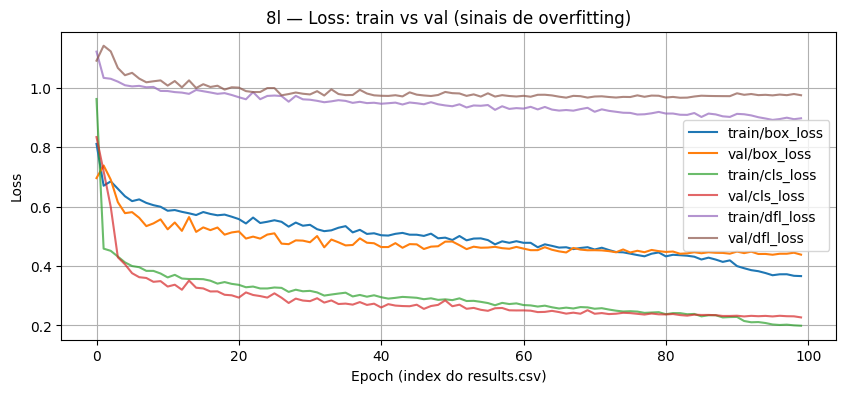

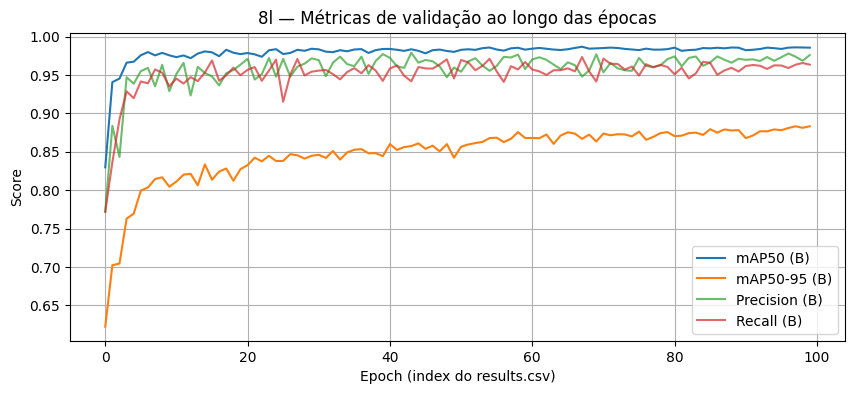


=== 8m ===
Best epoch idx: 96 | Last idx: 99
Best mAP50-95: 0.8793 | Last mAP50-95: 0.8787 | Drop(best->last): 0.0006
Gap (val-train) box loss last: 0.06807000000000002


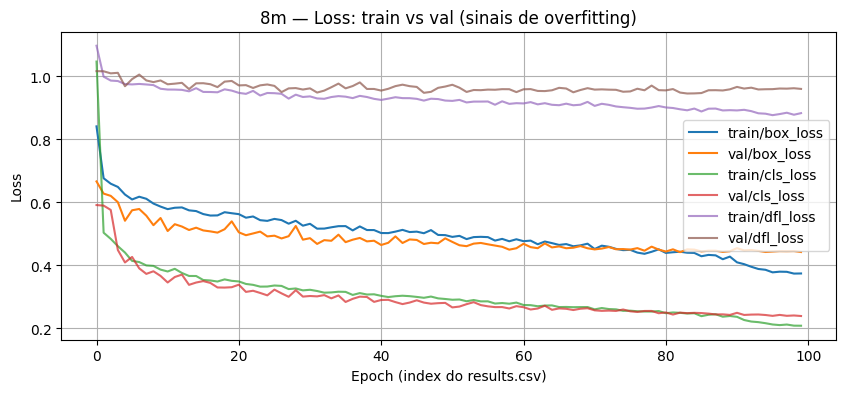

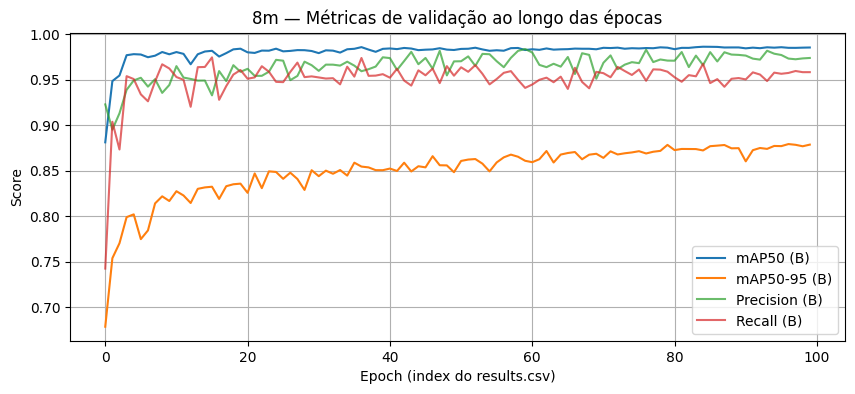


=== 8n ===
Best epoch idx: 88 | Last idx: 99
Best mAP50-95: 0.8605 | Last mAP50-95: 0.8562 | Drop(best->last): 0.0043
Gap (val-train) box loss last: 0.0015999999999999903


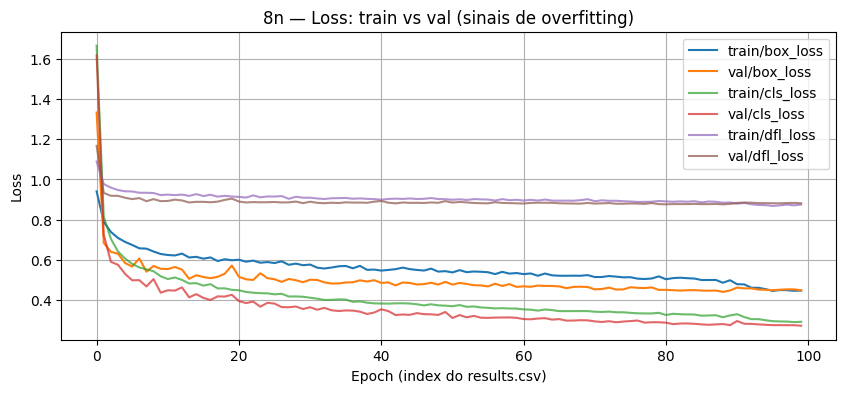

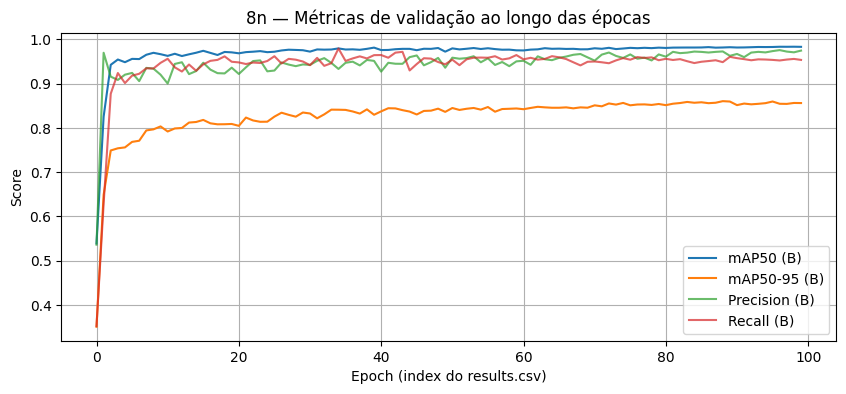


=== 11l ===
Best epoch idx: 98 | Last idx: 99
Best mAP50-95: 0.882 | Last mAP50-95: 0.8805 | Drop(best->last): 0.0014
Gap (val-train) box loss last: 0.04099999999999998


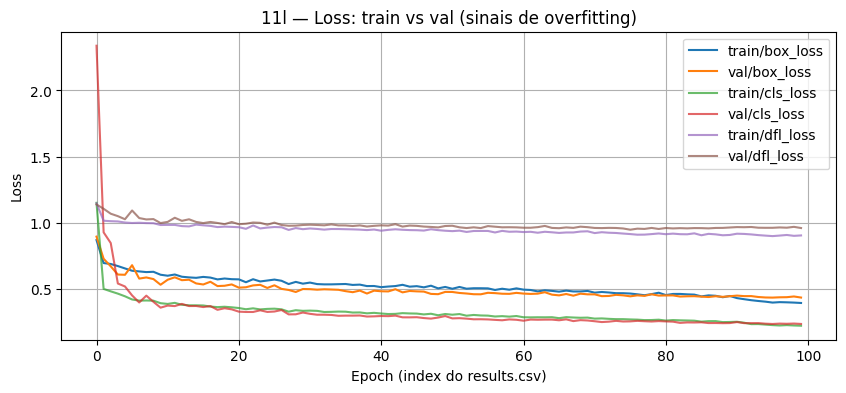

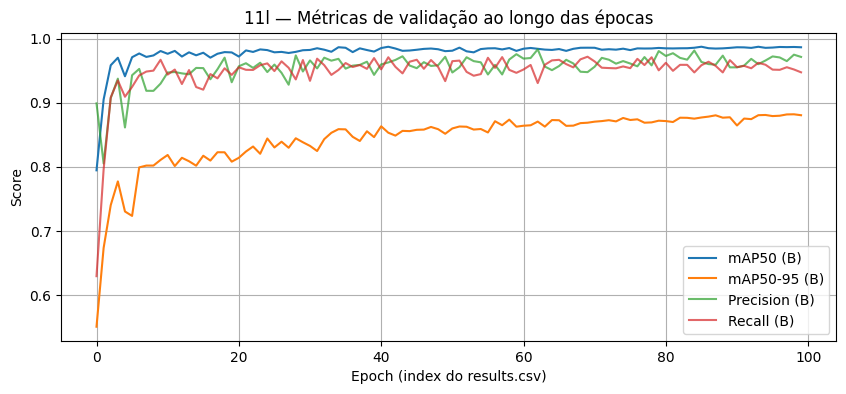


=== 11m ===
Best epoch idx: 89 | Last idx: 99
Best mAP50-95: 0.8859 | Last mAP50-95: 0.8829 | Drop(best->last): 0.0029
Gap (val-train) box loss last: 0.04025000000000001


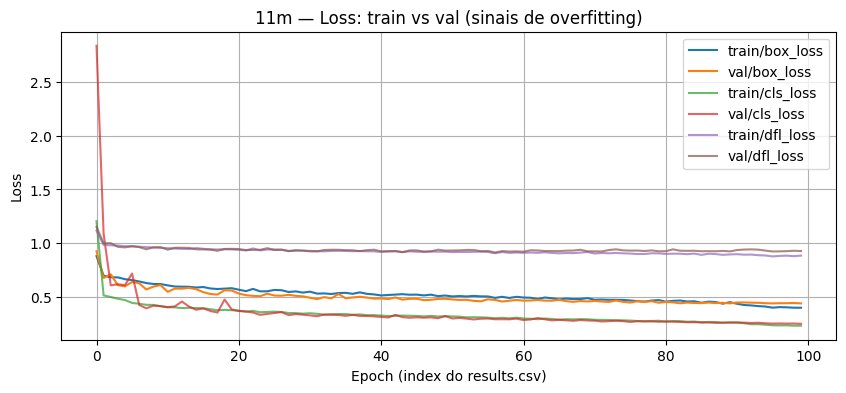

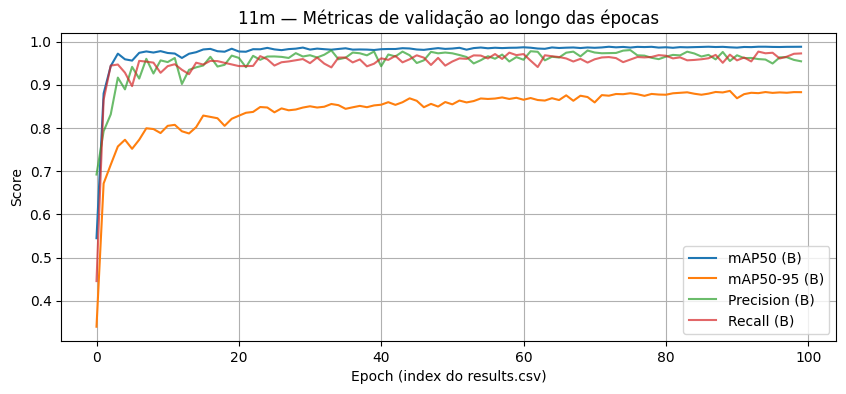


=== 11n ===
Best epoch idx: 84 | Last idx: 99
Best mAP50-95: 0.861 | Last mAP50-95: 0.8562 | Drop(best->last): 0.0048
Gap (val-train) box loss last: -0.006399999999999961


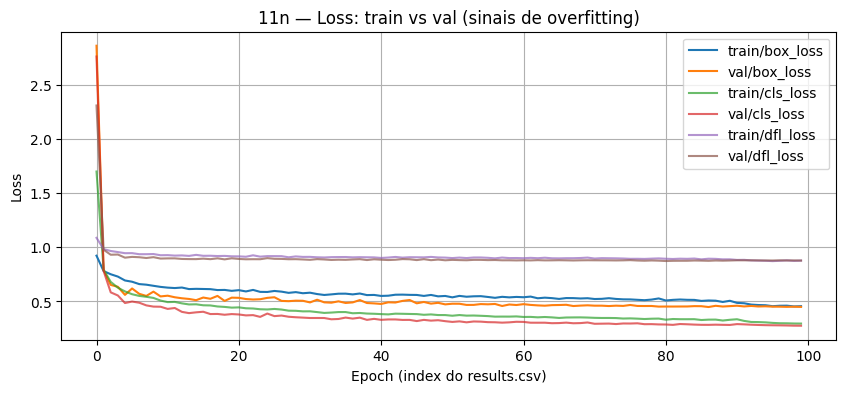

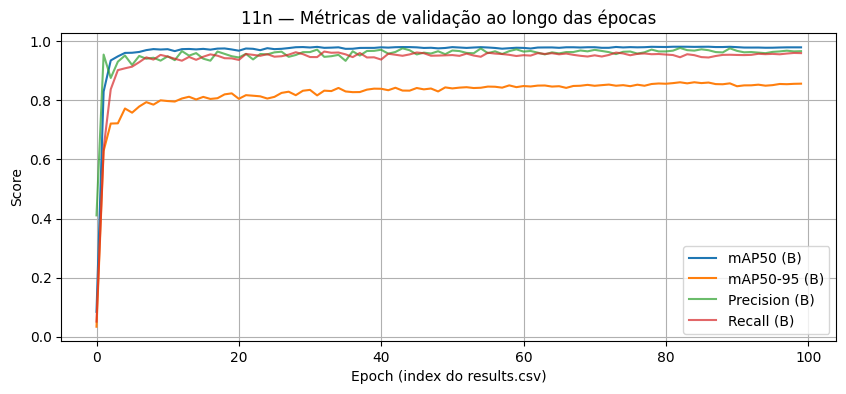

In [2]:
display(summary.reset_index(drop=True))

for name, run_dir, df, info in runs:
    print(f"\n=== {name} ===")
    print("Best epoch idx:", info["best_epoch_idx"], "| Last idx:", info["last_epoch_idx"])
    print("Best mAP50-95:", round(info["best_mAP50_95"], 4), "| Last mAP50-95:", round(info["last_mAP50_95"], 4),
          "| Drop(best->last):", round(info["drop_best_to_last_mAP50_95"], 4))
    print("Gap (val-train) box loss last:", info["gap_val_minus_train_box_loss_last"])
    plot_run_curves(name, df)
